In [11]:
print('\033[1m'+"Project 5: Predicting Employee Attrition in an Organization" + '\033[1m'+ " submission by Ayush Maurya E22CSEU1586")

Project 5: Predicting Employee Attrition in an Organization submission by Ayush Maurya E22CSEU1586


In [12]:
# pip install pyspark

Creating Spark Session


In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Employee Attrition Prediction") \
    .getOrCreate()



Reading dataset

In [57]:
file_path = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)
data.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [58]:
print(f"Number of rows: {data.count()}")
print(f"Number of columns: {len(data.columns)}")

Number of rows: 1470
Number of columns: 35


In [59]:
print("Columns are: ",data.columns)

Columns are:  ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [60]:
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

In [61]:
data.describe().show()

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|               Age|Attrition|BusinessTravel|         DailyRate|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|   EmployeeNumber|EnvironmentSatisfaction|Gender|        HourlyRate|    JobInvolvement|          JobLevel|             JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|       MonthlyRate|NumCompaniesWorked|O

Here we dropped few unnecessary columns.

In [62]:
data=data.drop("EmployeeCount", "EmployeeNumber", "StandardHours")

Checking for misiing values.

In [63]:
from pyspark.sql.functions import col, sum

missing_values = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
missing_values.show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+--------------+---------+----------+-----

No missing values were found

Finding numerical and categorical columns.

In [64]:
numerical_columns = [c[0] for c in data.dtypes if c[1] in ['int', 'double', 'float']]
categorical_columns = [c[0] for c in data.dtypes if c[1] == 'string']

print("Numerical Columns: ", numerical_columns)
print("Categorical Columns: ", categorical_columns)

Numerical Columns:  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical Columns:  ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


Checking for distinct values of categorical columns.

In [65]:
for col in categorical_columns:
    data.select(col).distinct().show()

+---------+
|Attrition|
+---------+
|       No|
|      Yes|
+---------+

+-----------------+
|   BusinessTravel|
+-----------------+
|Travel_Frequently|
|       Non-Travel|
|    Travel_Rarely|
+-----------------+

+--------------------+
|          Department|
+--------------------+
|               Sales|
|Research & Develo...|
|     Human Resources|
+--------------------+

+----------------+
|  EducationField|
+----------------+
|Technical Degree|
|           Other|
|       Marketing|
|         Medical|
|   Life Sciences|
| Human Resources|
+----------------+

+------+
|Gender|
+------+
|Female|
|  Male|
+------+

+--------------------+
|             JobRole|
+--------------------+
|     Sales Executive|
|Manufacturing Dir...|
|Laboratory Techni...|
|Sales Representative|
|Healthcare Repres...|
|  Research Scientist|
|             Manager|
|   Research Director|
|     Human Resources|
+--------------------+

+-------------+
|MaritalStatus|
+-------------+
|      Married|
|     Divorced

In [66]:
data=data.drop("Over18")
categorical_columns.remove("Over18")

**EDA**

In [67]:
df_pandas = data.toPandas()


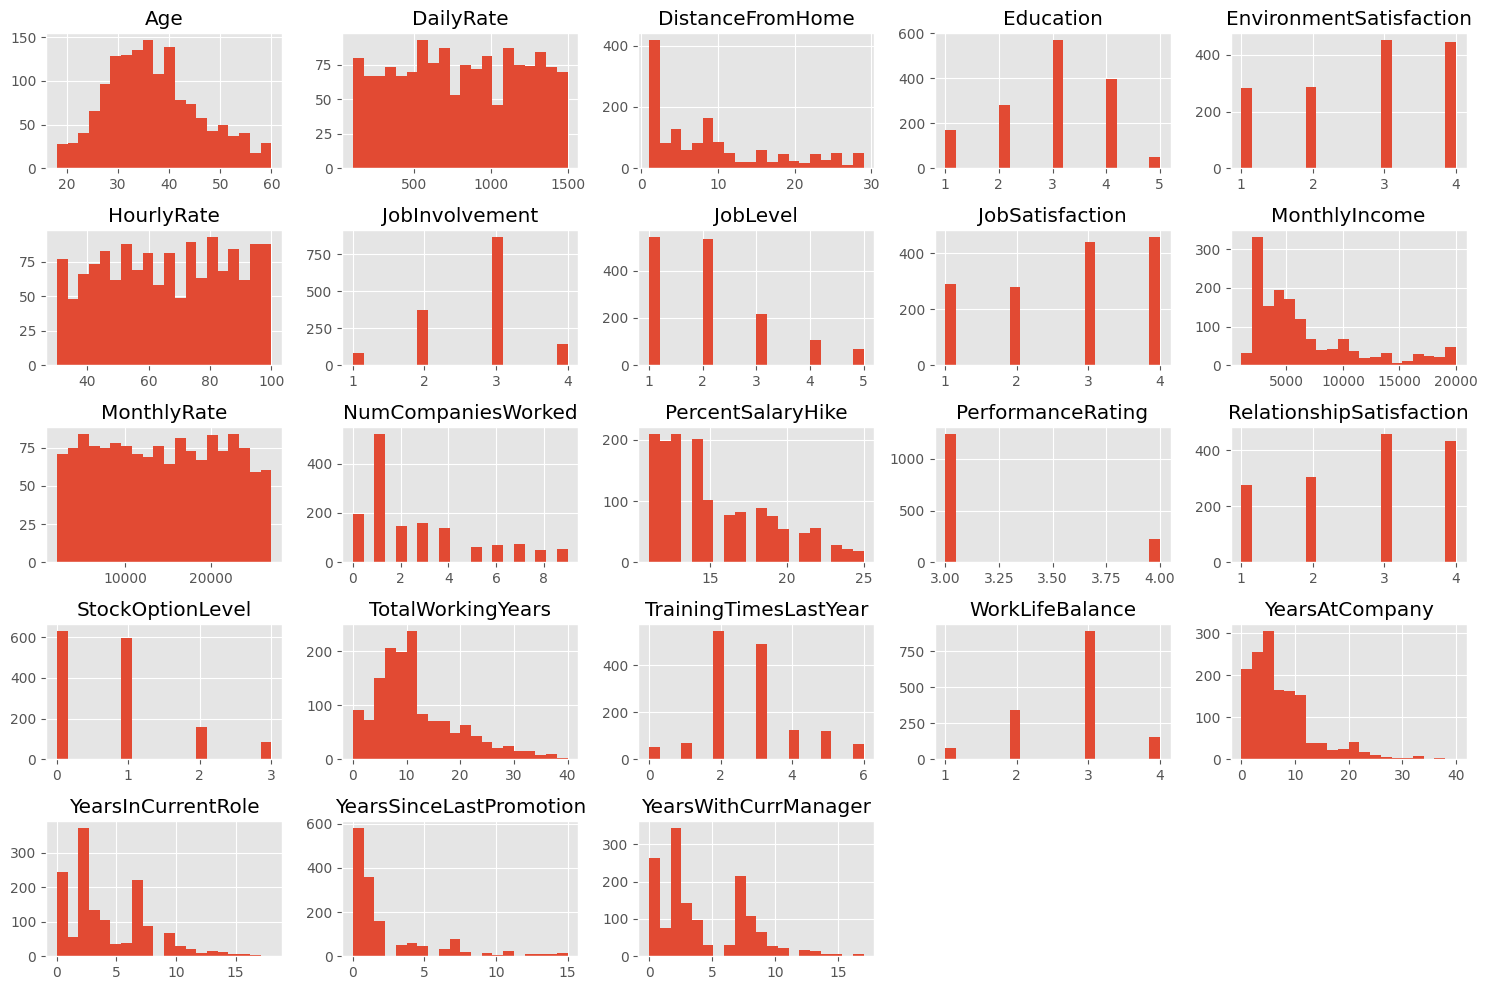

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas[numerical_columns].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()


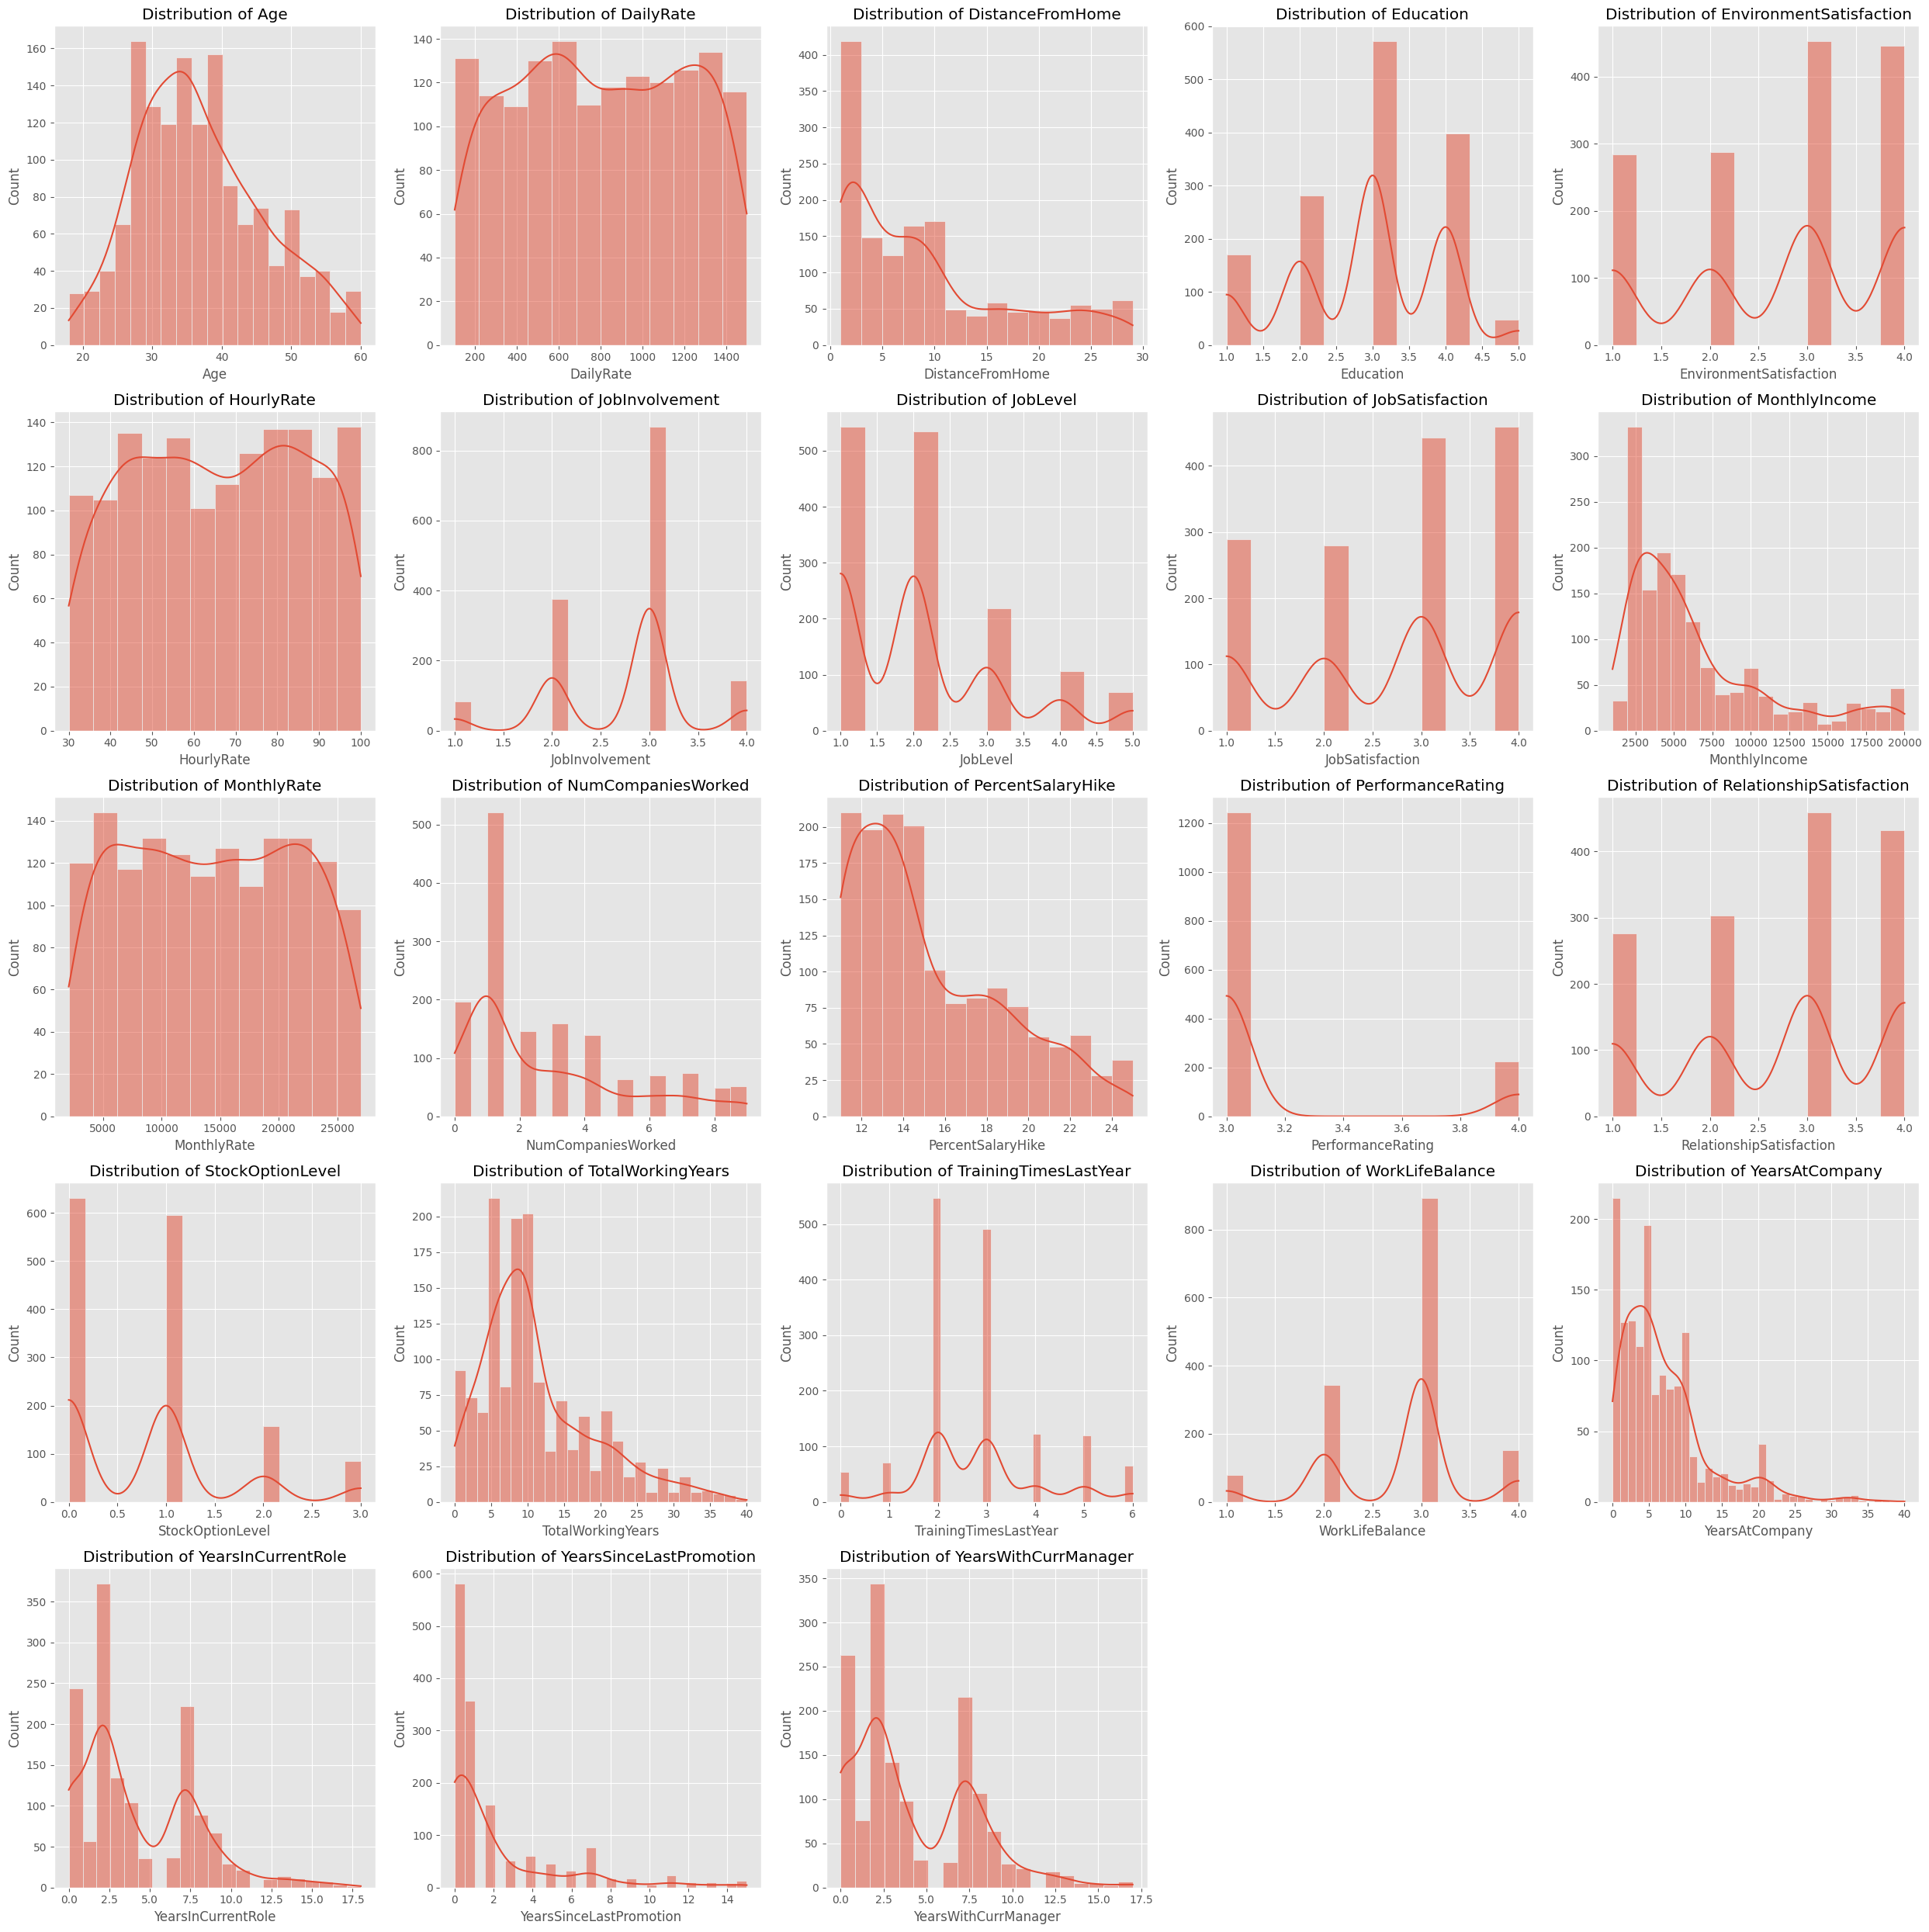

Age                         0.413286
DailyRate                  -0.003519
DistanceFromHome            0.958118
Education                  -0.289681
EnvironmentSatisfaction    -0.321654
HourlyRate                 -0.032311
JobInvolvement             -0.498419
JobLevel                    1.025401
JobSatisfaction            -0.329672
MonthlyIncome               1.369817
MonthlyRate                 0.018578
NumCompaniesWorked          1.026471
PercentSalaryHike           0.821128
PerformanceRating           1.921883
RelationshipSatisfaction   -0.302828
StockOptionLevel            0.968980
TotalWorkingYears           1.117172
TrainingTimesLastYear       0.553124
WorkLifeBalance            -0.552480
YearsAtCompany              1.764529
YearsInCurrentRole          0.917363
YearsSinceLastPromotion     1.984290
YearsWithCurrManager        0.833451
dtype: float64


In [71]:
import math

# Number of features
num_features = len(numerical_columns)

# Calculate number of rows and columns for subplots
num_cols = 5
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df_pandas[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

print(df_pandas[numerical_columns].skew())


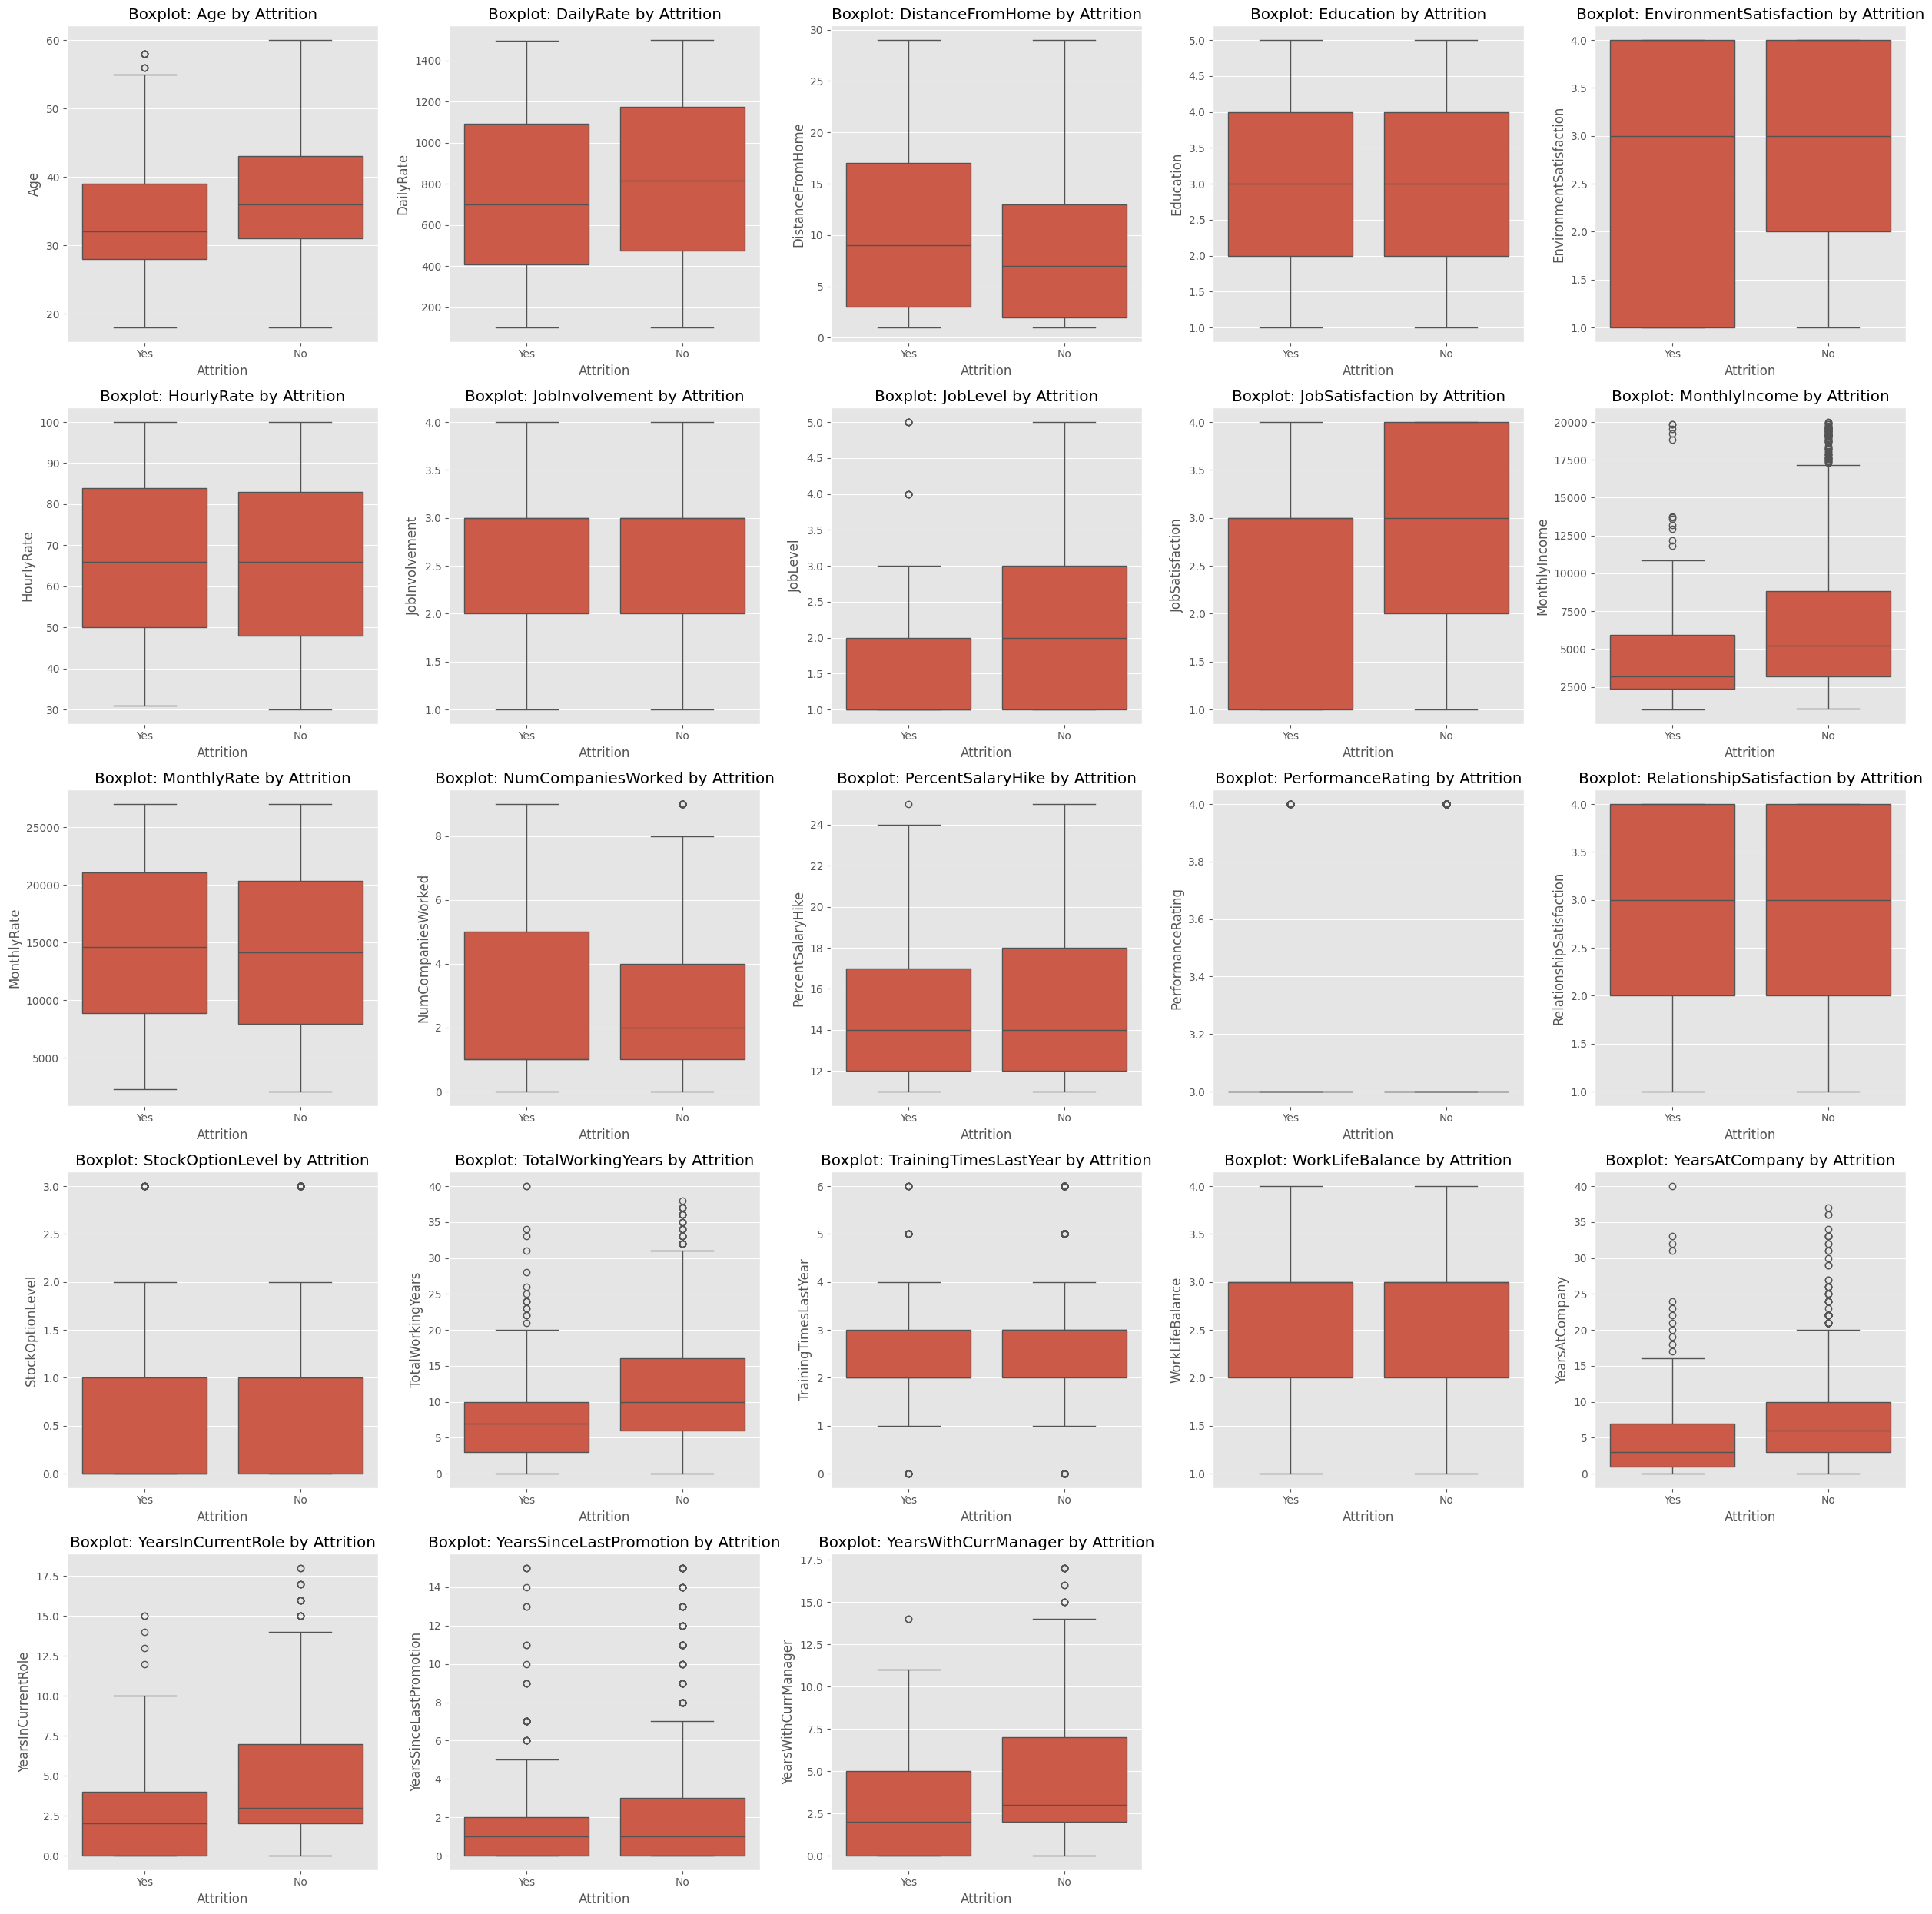

In [73]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Number of features
num_features = len(numerical_columns)

# Calculate number of rows and columns for subplots
num_cols = 5
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='Attrition', y=feature, data=df_pandas)
    plt.title(f'Boxplot: {feature} by Attrition')

plt.tight_layout()
plt.show()


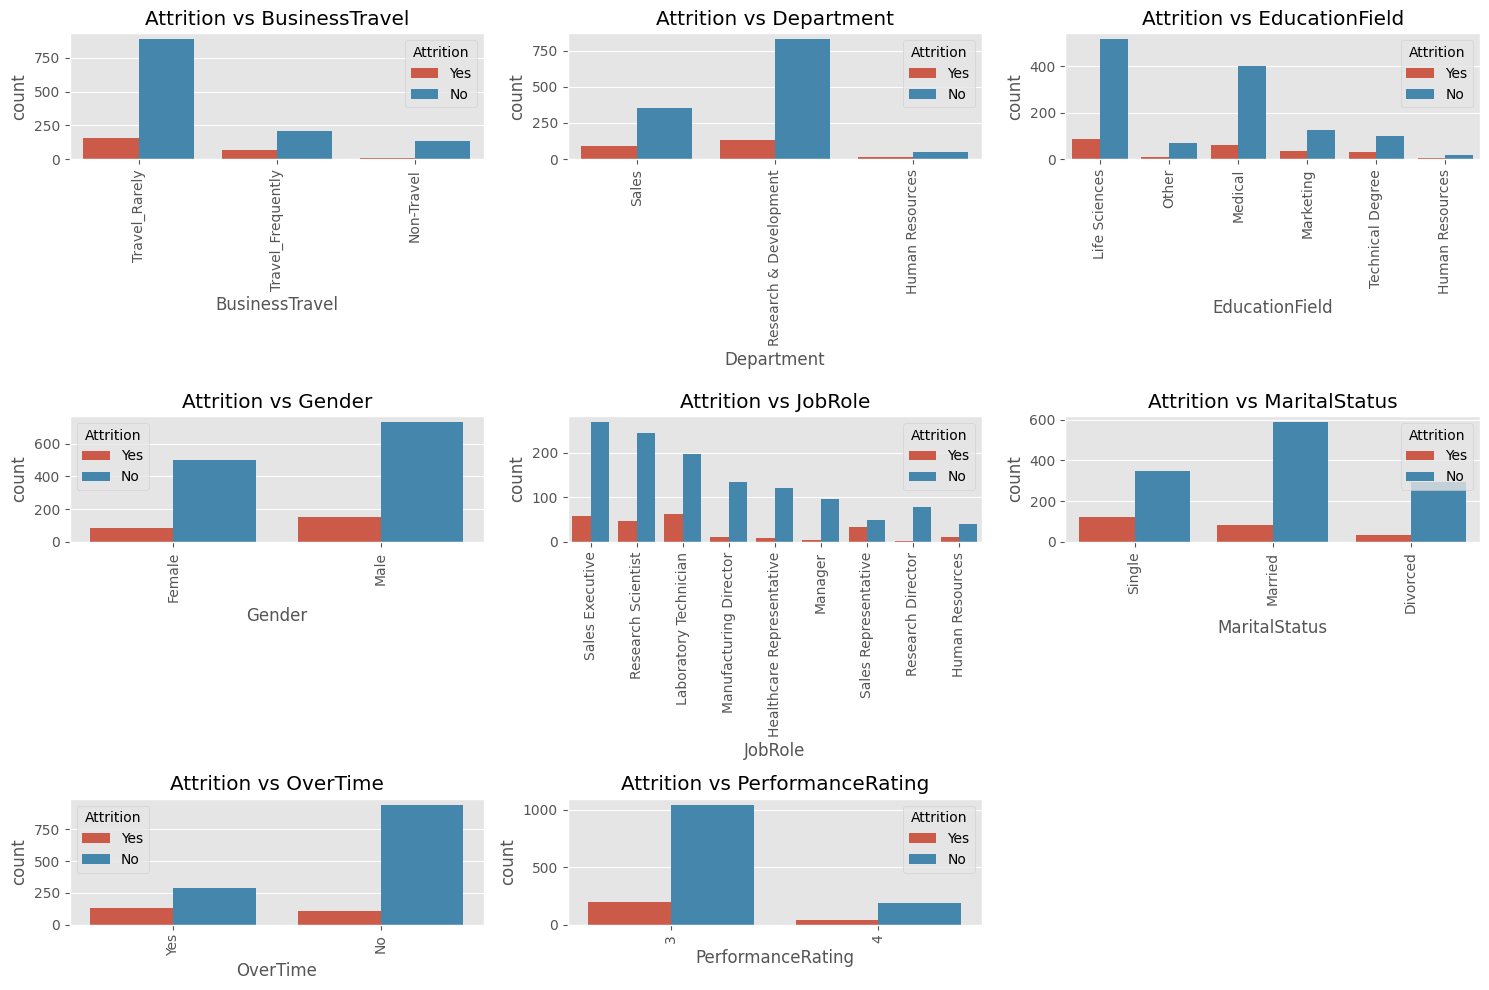

In [78]:
# Bar plots for categorical features with respect to Attrition
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender',
                        'JobRole', 'MaritalStatus', 'OverTime', 'PerformanceRating']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='Attrition', data=df_pandas)
    plt.title(f'Attrition vs {feature}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


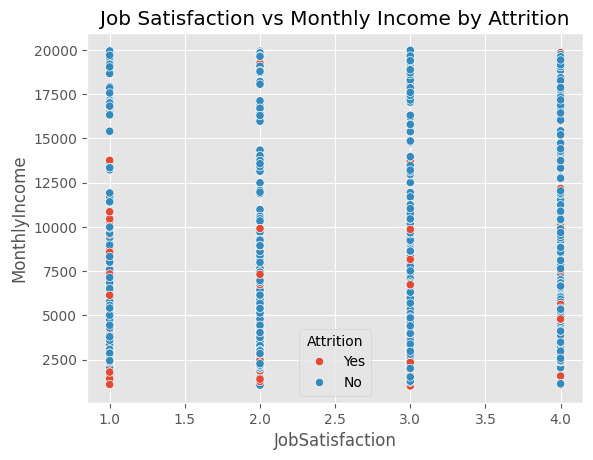

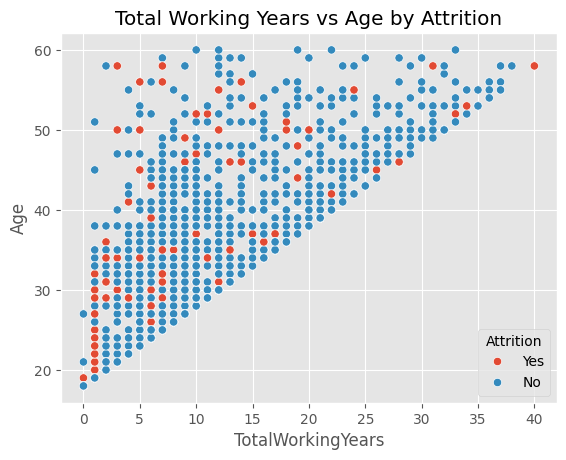

In [75]:
# Example: Interactions between job satisfaction and monthly income
sns.scatterplot(x='JobSatisfaction', y='MonthlyIncome', hue='Attrition', data=df_pandas)
plt.title('Job Satisfaction vs Monthly Income by Attrition')
plt.show()

# Example: Interactions between total working years and age
sns.scatterplot(x='TotalWorkingYears', y='Age', hue='Attrition', data=df_pandas)
plt.title('Total Working Years vs Age by Attrition')
plt.show()


**Preprocessing**

Converting categorical columns to numerical columns and applying One Hot Encoding.

In [24]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_columns = ["Gender", "JobRole", "Department", "BusinessTravel", "OverTime", "MaritalStatus"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe") for col in categorical_columns]

# Create a pipeline
pipeline = Pipeline(stages=indexers + encoders)
data = pipeline.fit(data).transform(data)


In [25]:
data.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+------------+-------------+----------------+--------------------+--------------+-------------------+-------------+-------------+--------------+------------------+-------------+-----------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|Re

In [26]:
data.columns

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Gender_index',
 'JobRole_index',
 'Department_index',
 'BusinessTravel_index',
 'OverTime_index',
 'MaritalStatus_index',
 'Gender_ohe',
 'JobRole_ohe',
 'Department_ohe',
 'BusinessTravel_ohe',
 'OverTime_ohe',
 'MaritalStatus_ohe']

In [27]:
from pyspark.sql.functions import expr
data = data.withColumn("Tenure", expr("YearsAtCompany - YearsInCurrentRole"))
data = data.withColumn("IncomeToJobLevelRatio", expr("MonthlyIncome / JobLevel"))


Converting target column from categorical to numerical.

In [28]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
data = indexer.fit(data).transform(data)

Here we are finding correlation of all columns with one another.

In [29]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
ind_columns = [col for col in data.columns if ('_index' in col and "Attrition_index" not in col)]
corr_col=numerical_columns+[col for col in data.columns if "Attrition_index" in col]+ind_columns
assembler = VectorAssembler(inputCols=corr_col, outputCol="features")
corr_data = assembler.transform(data)
pearson_corr = Correlation.corr(corr_data, "features").head()[0]
print(f"Pearson correlation matrix:\n{pearson_corr}")


Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  1.06609426e-02, -1.68612015e-03,
               2.08033731e-01,  1.01464279e-02,  2.42865426e-02,
               2.98199586e-02,  5.09604228e-01, -4.89187715e-03,
               4.97854567e-01,  2.80511671e-02,  2.99634758e-01,
               3.63358491e-03,  1.90389551e-03,  5.35347197e-02,
               3.75097124e-02,  6.80380536e-01, -1.96208189e-02,
              -2.14900280e-02,  3.11308770e-01,  2.12901056e-01,
               2.16513368e-01,  2.02088602e-01, -1.59205007e-01,
               3.63105501e-02,  1.59715012e-01, -7.65201603e-03,
              -2.47514342e-02,  2.80623571e-02, -3.54661918e-02],
             [ 1.06609426e-02,  1.00000000e+00, -4.98533735e-03,
              -1.68064332e-02,  1.83548543e-02,  2.33814215e-02,
               4.61348740e-02,  2.96633486e-03,  3.05710078e-02,
               7.70705887e-03, -3.21816015e-02,  3.81534343e-02,
               2.27036775e-02,  4.73296327e-04,  7.84603096e-

In [30]:
print(corr_col)

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_index', 'Gender_index', 'JobRole_index', 'Department_index', 'BusinessTravel_index', 'OverTime_index', 'MaritalStatus_index']


Visualizing the correlation matrix and doing feature selection.

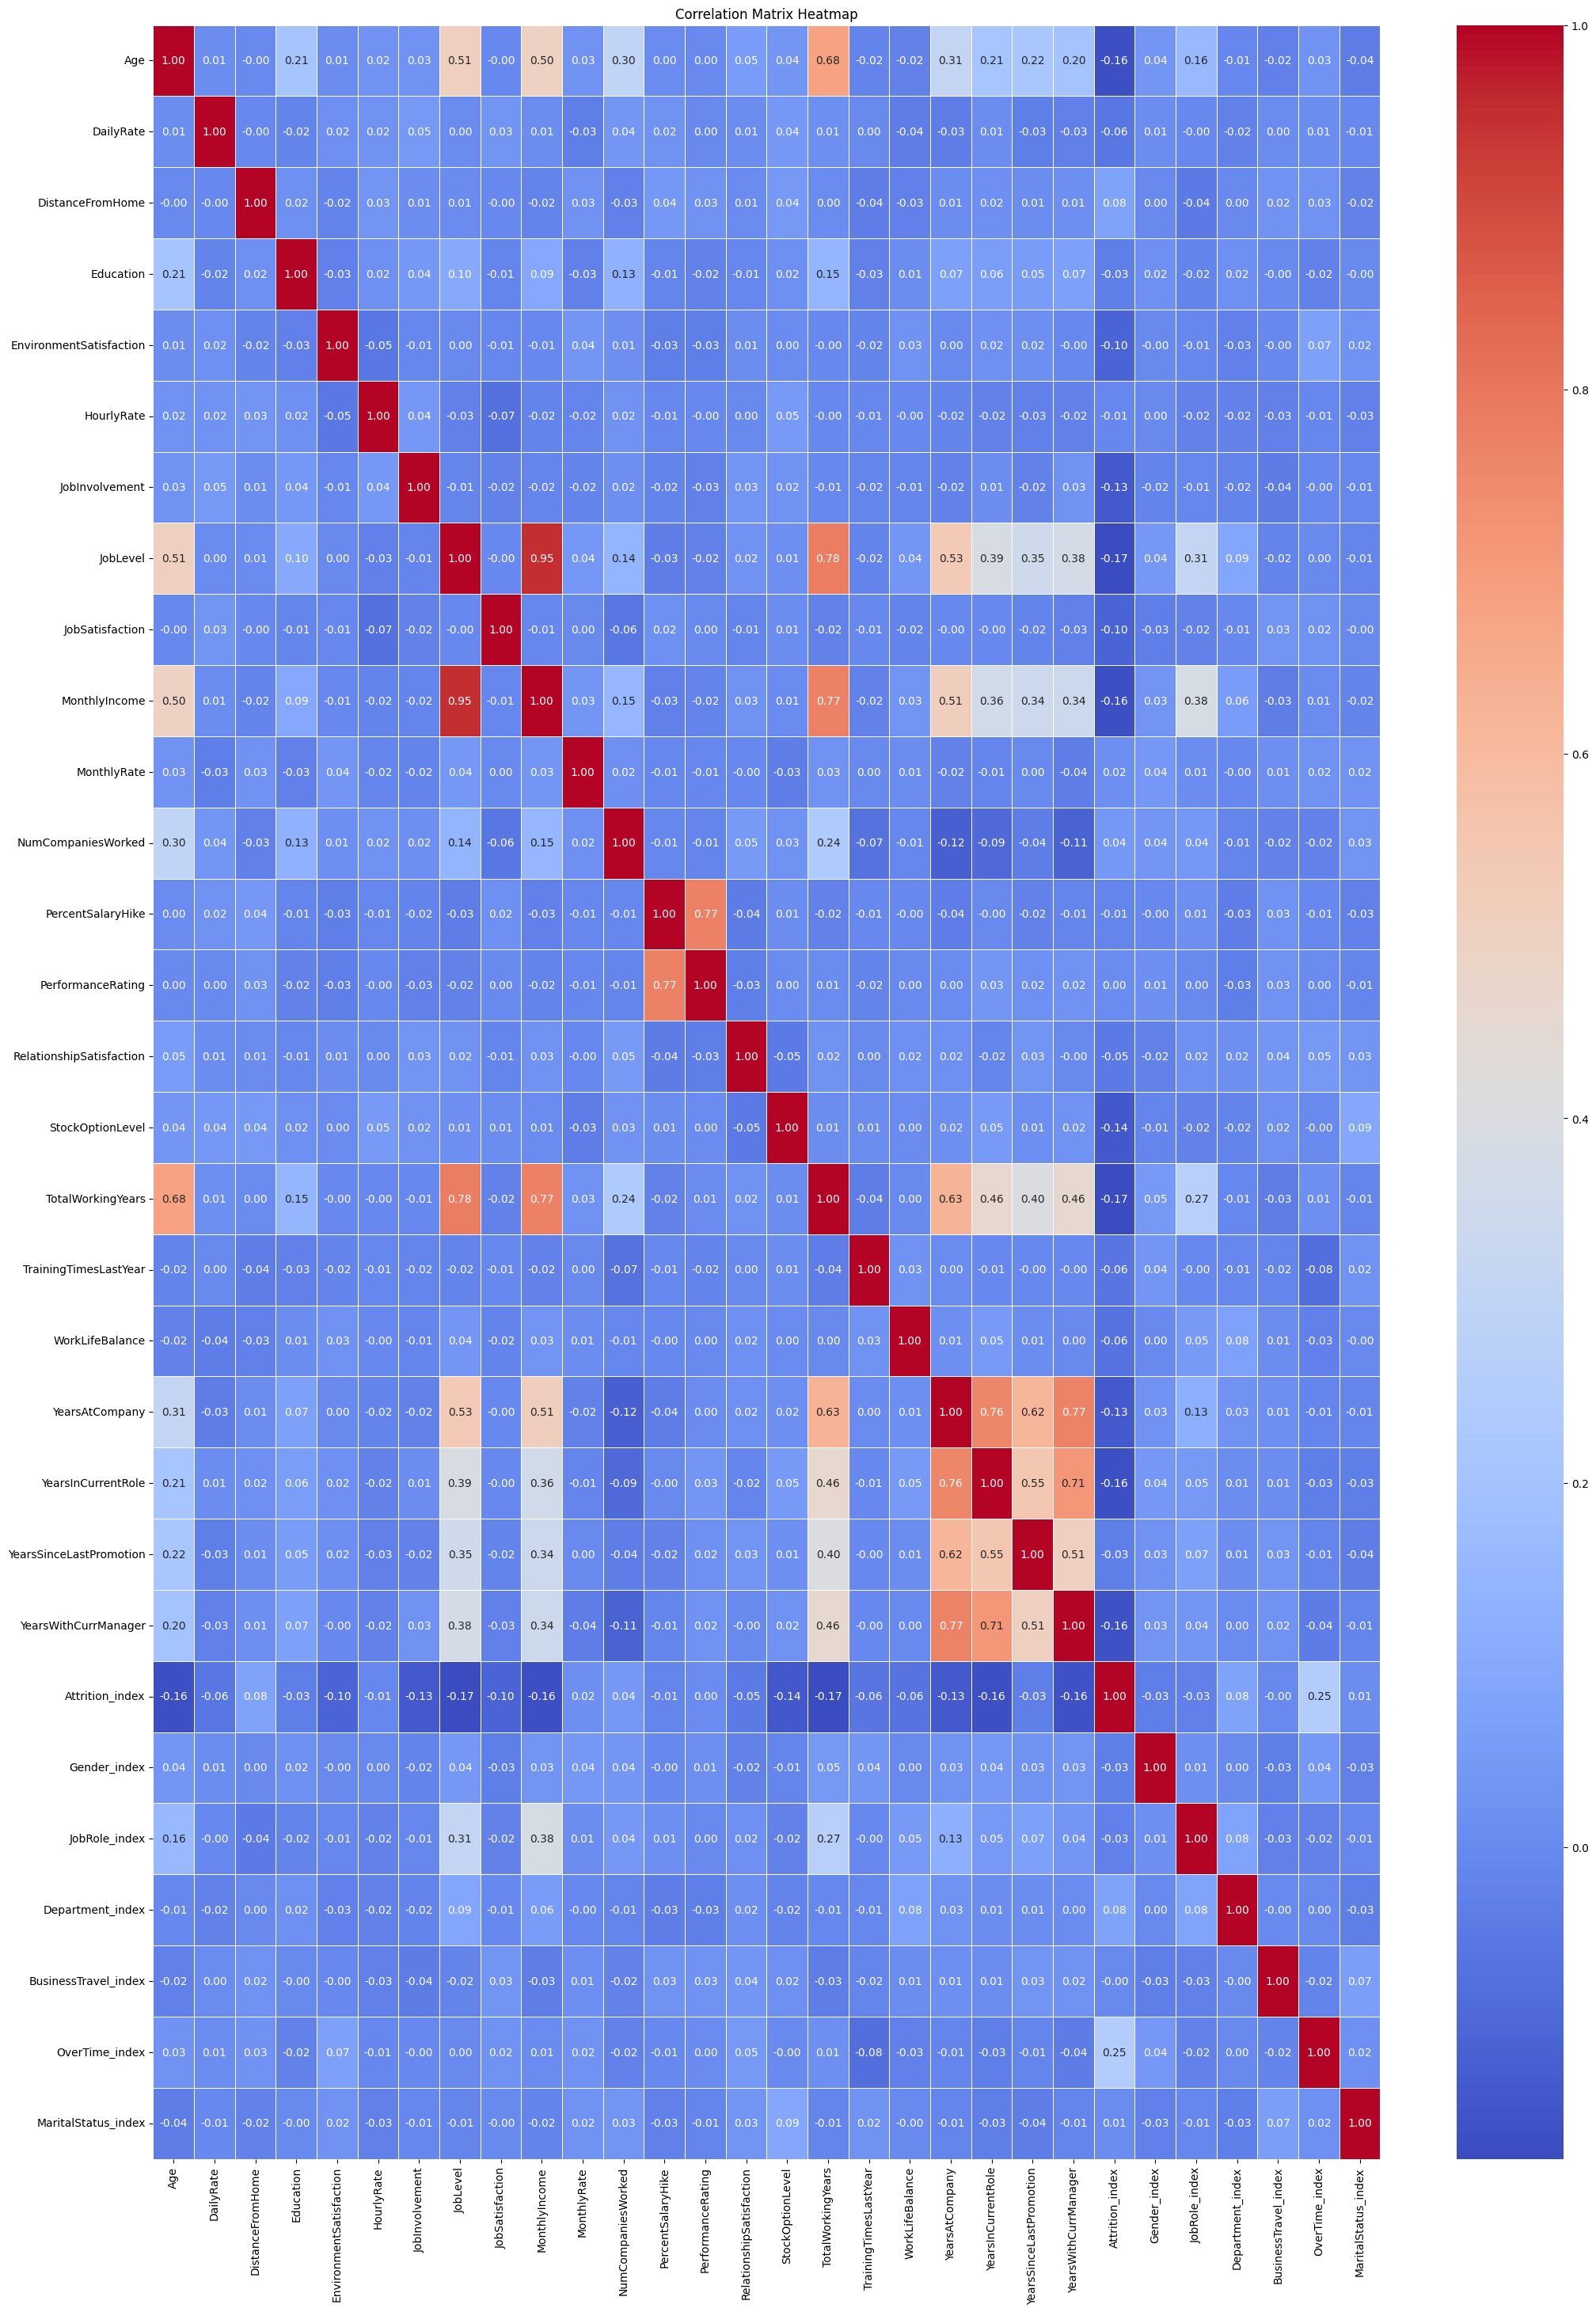

Selected Features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Department_index', 'OverTime_index']
All Columns Correlation with Attrition_Index:
 Age                        -0.159205
DailyRate                  -0.056652
DistanceFromHome            0.077924
Education                  -0.031373
EnvironmentSatisfaction    -0.103369
HourlyRate                 -0.006846
JobInvolvement             -0.130016
JobLevel                   -0.169105
JobSatisfaction            -0.103481
MonthlyIncome              -0.159840
MonthlyRate                 0.015170
NumCompaniesWorked          0.043494
PercentSalaryHike          -0.013478
PerformanceRating           0.002889
Relat

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = np.array(pearson_corr.toArray())
feature_names = assembler.getInputCols()


if corr_matrix.shape[0] == len(feature_names):
    corr_df = pd.DataFrame(corr_matrix, index=feature_names, columns=feature_names)

    plt.figure(figsize=(25, 35))
    sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

    # Get the absolute correlations with the target column
    corr_with_target = corr_df['Attrition_index'].abs()

    # Feature selection
    threshold = 0.03
    selected_features = corr_with_target[corr_with_target >= threshold].index.drop('Attrition_index').tolist()

    print("Selected Features:", selected_features)
    print("All Columns Correlation with Attrition_Index:\n", corr_df['Attrition_index'])

else:
    print("Mismatch between correlation matrix shape and feature names length.")

filtered_df = data.select(*selected_features, 'Attrition_index')
filtered_df.show()


Scaling the selected features to prepare it for training.

In [32]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

ohe_columns = [col for col in data.columns if '_ohe' in col]
ind_columns = [col for col in data.columns if ('_index' in col and "Attrition_index" not in col)]
selected_columns = selected_features
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(data)

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.drop("features")
data.show()


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+------------+-------------+----------------+--------------------+--------------+-------------------+-------------+-------------+--------------+------------------+-------------+-----------------+------+---------------------+---------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|

In [33]:
print(selected_columns)

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Department_index', 'OverTime_index']


Checking for class distribution.

In [34]:
data.groupBy("Attrition").count().show()


+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



Stratifying so to have original distribution of data in train and test too.

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

def stratified_split(df, strata_col, train_fraction, seed):
    strata = df.select(strata_col).distinct().collect()
    train_list = []
    test_list = []

    for stratum in strata:
        stratum_value = stratum[strata_col]
        stratum_df = df.filter(col(strata_col) == stratum_value)
        train_stratum, test_stratum = stratum_df.randomSplit([train_fraction, 1 - train_fraction], seed)
        train_list.append(train_stratum)
        test_list.append(test_stratum)

    train_data = train_list[0]
    for train_stratum in train_list[1:]:
        train_data = train_data.union(train_stratum)

    test_data = test_list[0]
    for test_stratum in test_list[1:]:
        test_data = test_data.union(test_stratum)

    return train_data, test_data

train_data, test_data = stratified_split(data, "Attrition_index", 0.8, seed=42)

print("Train Data Distribution:")
train_data.groupBy("Attrition").count().show()

print("Test Data Distribution:")
test_data.groupBy("Attrition").count().show()



Train Data Distribution:
+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1023|
|      Yes|  202|
+---------+-----+

Test Data Distribution:
+---------+-----+
|Attrition|count|
+---------+-----+
|       No|  210|
|      Yes|   35|
+---------+-----+



LogisticRegression

In [36]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Attrition_index")
lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)
lr_predictions.select("Attrition", "Attrition_index", "prediction", "probability").show()
lr_predictions.groupBy("Attrition_index", "prediction").count().show()

+---------+---------------+----------+--------------------+
|Attrition|Attrition_index|prediction|         probability|
+---------+---------------+----------+--------------------+
|       No|            0.0|       0.0|[0.72757821503949...|
|       No|            0.0|       0.0|[0.82217846253531...|
|       No|            0.0|       0.0|[0.65641244257850...|
|       No|            0.0|       0.0|[0.90793921470916...|
|       No|            0.0|       1.0|[0.11369035315989...|
|       No|            0.0|       0.0|[0.86142568648898...|
|       No|            0.0|       0.0|[0.95534171808765...|
|       No|            0.0|       0.0|[0.97058887658457...|
|       No|            0.0|       0.0|[0.52848721628819...|
|       No|            0.0|       0.0|[0.82611241590240...|
|       No|            0.0|       0.0|[0.87426050334223...|
|       No|            0.0|       0.0|[0.86486055587183...|
|       No|            0.0|       0.0|[0.86099745555454...|
|       No|            0.0|       0.0|[0

DecisionTreeClassifier

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="Attrition_index",maxBins=100)
dt_model = dt.fit(train_data)

dt_predictions = dt_model.transform(test_data)
dt_predictions.select("Attrition", "Attrition_index", "prediction", "probability").show()

+---------+---------------+----------+--------------------+
|Attrition|Attrition_index|prediction|         probability|
+---------+---------------+----------+--------------------+
|       No|            0.0|       1.0|           [0.0,1.0]|
|       No|            0.0|       0.0|[0.90909090909090...|
|       No|            0.0|       0.0|[0.72727272727272...|
|       No|            0.0|       0.0|[0.72727272727272...|
|       No|            0.0|       0.0|[0.51724137931034...|
|       No|            0.0|       0.0|[0.72727272727272...|
|       No|            0.0|       0.0|[0.72727272727272...|
|       No|            0.0|       0.0|[0.94417077175697...|
|       No|            0.0|       1.0|           [0.0,1.0]|
|       No|            0.0|       0.0|[0.94417077175697...|
|       No|            0.0|       0.0|[0.72727272727272...|
|       No|            0.0|       0.0|[0.94417077175697...|
|       No|            0.0|       0.0|[0.73913043478260...|
|       No|            0.0|       0.0|[0

Decision Tree Feature Importances:
                     Feature  Importance
8              MonthlyIncome    0.178919
20            OverTime_index    0.164783
4    EnvironmentSatisfaction    0.105397
11          StockOptionLevel    0.103244
12         TotalWorkingYears    0.067336
2           DistanceFromHome    0.064487
9         NumCompaniesWorked    0.052424
1                  DailyRate    0.043550
10  RelationshipSatisfaction    0.042232
0                        Age    0.040939
5             JobInvolvement    0.038517
14           WorkLifeBalance    0.027668
19          Department_index    0.025820
16        YearsInCurrentRole    0.023504
17   YearsSinceLastPromotion    0.021180
3                  Education    0.000000
7            JobSatisfaction    0.000000
6                   JobLevel    0.000000
13     TrainingTimesLastYear    0.000000
15            YearsAtCompany    0.000000
18      YearsWithCurrManager    0.000000


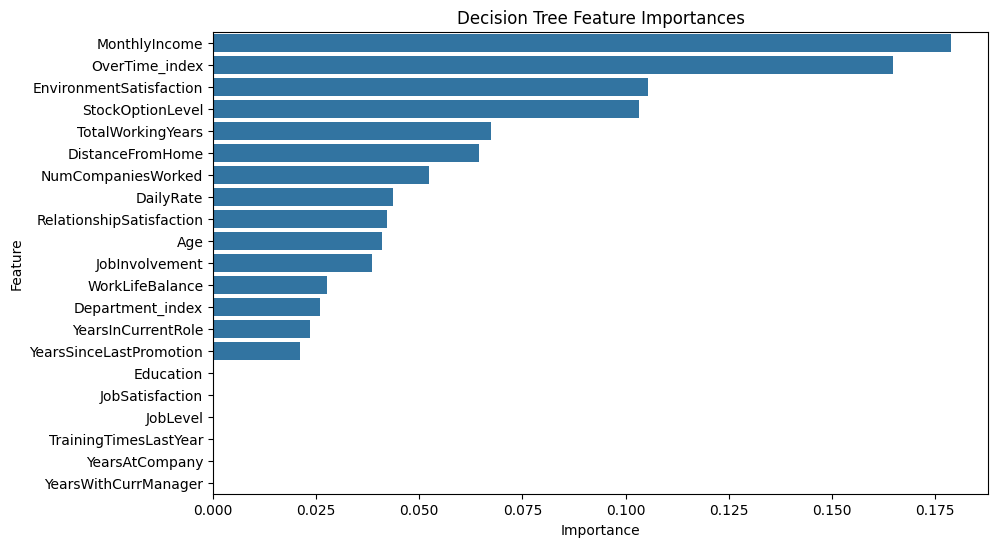

In [38]:
dt_feature_importances = dt_model.featureImportances
feature_names = assembler.getInputCols()
dt_feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, dt_feature_importances)}

dt_feature_importance_df = pd.DataFrame(list(dt_feature_importance_dict.items()), columns=["Feature", "Importance"])
dt_feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print("Decision Tree Feature Importances:")
print(dt_feature_importance_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=dt_feature_importance_df)
plt.title("Decision Tree Feature Importances")
plt.show()


RandomForestClassifier

In [39]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Attrition_index",maxBins=73)
rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)
rf_predictions.select("Attrition", "Attrition_index", "prediction", "probability").show()

+---------+---------------+----------+--------------------+
|Attrition|Attrition_index|prediction|         probability|
+---------+---------------+----------+--------------------+
|       No|            0.0|       1.0|[0.48505700334170...|
|       No|            0.0|       0.0|[0.55647172042065...|
|       No|            0.0|       0.0|[0.75641977042435...|
|       No|            0.0|       0.0|[0.64402850365892...|
|       No|            0.0|       1.0|[0.49928734708947...|
|       No|            0.0|       0.0|[0.68081827642227...|
|       No|            0.0|       0.0|[0.78265951290742...|
|       No|            0.0|       0.0|[0.84652267997616...|
|       No|            0.0|       0.0|[0.57828207111912...|
|       No|            0.0|       0.0|[0.89054855703137...|
|       No|            0.0|       0.0|[0.55651672473491...|
|       No|            0.0|       0.0|[0.86061985971975...|
|       No|            0.0|       0.0|[0.66942008981457...|
|       No|            0.0|       0.0|[0

Random Forest Feature Importances:
                     Feature  Importance
20            OverTime_index    0.152075
12         TotalWorkingYears    0.108269
2           DistanceFromHome    0.075927
8              MonthlyIncome    0.075549
0                        Age    0.070048
11          StockOptionLevel    0.068035
16        YearsInCurrentRole    0.051904
1                  DailyRate    0.050049
15            YearsAtCompany    0.049922
4    EnvironmentSatisfaction    0.048195
9         NumCompaniesWorked    0.047320
14           WorkLifeBalance    0.030078
13     TrainingTimesLastYear    0.029049
7            JobSatisfaction    0.028768
6                   JobLevel    0.028763
5             JobInvolvement    0.022028
18      YearsWithCurrManager    0.019595
19          Department_index    0.015818
17   YearsSinceLastPromotion    0.013935
10  RelationshipSatisfaction    0.011637
3                  Education    0.003036


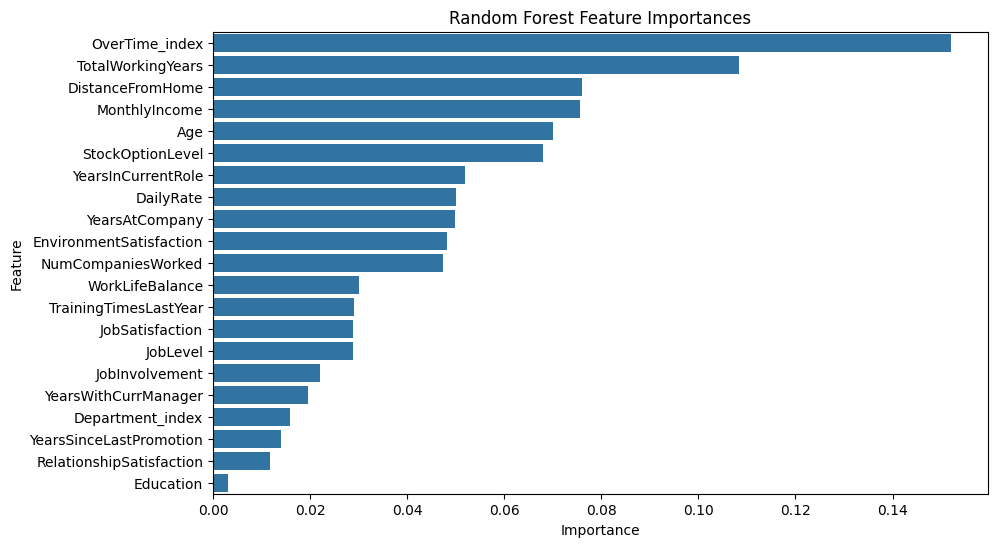

In [40]:
rf_feature_importances = rf_model.featureImportances
rf_feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, rf_feature_importances)}

rf_feature_importance_df = pd.DataFrame(list(rf_feature_importance_dict.items()), columns=["Feature", "Importance"])
rf_feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print("Random Forest Feature Importances:")
print(rf_feature_importance_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance_df)
plt.title("Random Forest Feature Importances")
plt.show()


GBTClassifier

In [41]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="scaled_features", labelCol="Attrition_index", maxIter=10)
gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select("Attrition", "Attrition_index", "prediction", "probability").show()

+---------+---------------+----------+--------------------+
|Attrition|Attrition_index|prediction|         probability|
+---------+---------------+----------+--------------------+
|       No|            0.0|       1.0|[0.13852499894970...|
|       No|            0.0|       0.0|[0.70904913156457...|
|       No|            0.0|       0.0|[0.70833288987855...|
|       No|            0.0|       0.0|[0.72620138908084...|
|       No|            0.0|       1.0|[0.13679706811383...|
|       No|            0.0|       0.0|[0.74249110771023...|
|       No|            0.0|       0.0|[0.83203818156465...|
|       No|            0.0|       0.0|[0.89103533454537...|
|       No|            0.0|       1.0|[0.38083074801566...|
|       No|            0.0|       0.0|[0.92402982230203...|
|       No|            0.0|       0.0|[0.77017655485581...|
|       No|            0.0|       0.0|[0.81415880808508...|
|       No|            0.0|       0.0|[0.63628458031130...|
|       No|            0.0|       0.0|[0

GBT Feature Importances:
                     Feature  Importance
0                        Age    0.121066
8              MonthlyIncome    0.075198
15            YearsAtCompany    0.074873
2           DistanceFromHome    0.070879
10  RelationshipSatisfaction    0.070545
20            OverTime_index    0.055323
11          StockOptionLevel    0.053241
1                  DailyRate    0.051833
5             JobInvolvement    0.051724
7            JobSatisfaction    0.050604
17   YearsSinceLastPromotion    0.048126
12         TotalWorkingYears    0.045421
9         NumCompaniesWorked    0.038074
13     TrainingTimesLastYear    0.036628
4    EnvironmentSatisfaction    0.032843
14           WorkLifeBalance    0.030792
16        YearsInCurrentRole    0.025448
19          Department_index    0.021941
3                  Education    0.020726
18      YearsWithCurrManager    0.015489
6                   JobLevel    0.009229


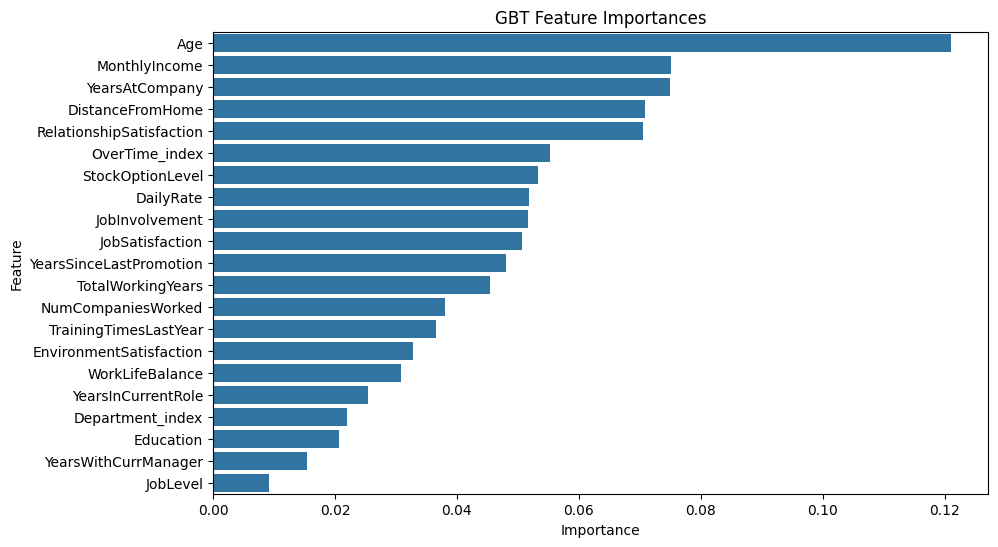

In [42]:
gbt_feature_importances = gbt_model.featureImportances

gbt_feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, gbt_feature_importances)}

gbt_feature_importance_df = pd.DataFrame(list(gbt_feature_importance_dict.items()), columns=["Feature", "Importance"])
gbt_feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

print("GBT Feature Importances:")
print(gbt_feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=gbt_feature_importance_df)
plt.title("GBT Feature Importances")
plt.show()


Evaluation metrics

--- Logistic Regression ---
Accuracy: 0.8980
Weightedprecision: 0.8890
Weightedrecall: 0.8980
F1: 0.8836
AUC: 0.7909




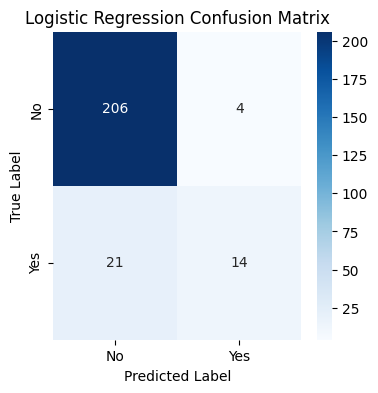

--- Decision Tree ---
Accuracy: 0.8327
Weightedprecision: 0.8005
Weightedrecall: 0.8327
F1: 0.8127
AUC: 0.3569




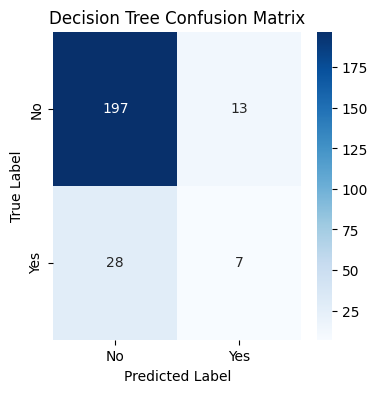

--- Random Forest ---
Accuracy: 0.8612
Weightedprecision: 0.8286
Weightedrecall: 0.8612
F1: 0.8138
AUC: 0.7739




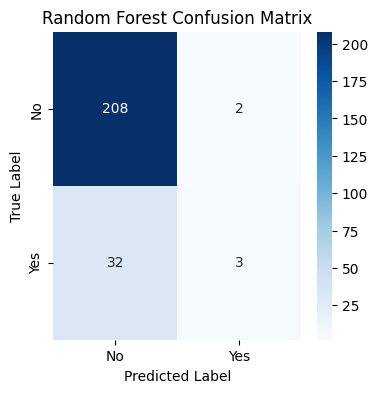

--- Gradient Boosted Trees ---
Accuracy: 0.8490
Weightedprecision: 0.8148
Weightedrecall: 0.8490
F1: 0.8241
AUC: 0.7498




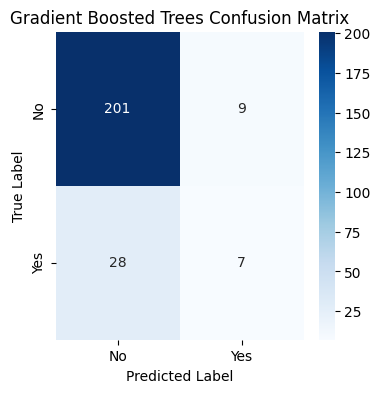

                    Model  Accuracy  Weightedprecision  Weightedrecall  \
0     Logistic Regression  0.897959           0.888959        0.897959   
1           Decision Tree  0.832653           0.800476        0.832653   
2           Random Forest  0.861224           0.828571        0.861224   
3  Gradient Boosted Trees  0.848980           0.814839        0.848980   

         F1       AUC  
0  0.883579  0.790884  
1  0.812718  0.356939  
2  0.813810  0.773946  
3  0.824116  0.749796  


In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

binary_evaluator = BinaryClassificationEvaluator(labelCol="Attrition_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction")

metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

def get_metrics_and_plot_confusion_matrix_with_auc(predictions, model_name):
    print(f"--- {model_name} ---")
    metrics_dict = {"Model": model_name}

    for metric in metrics:
        score = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        print(f"{metric.capitalize()}: {score:.4f}")
        metrics_dict[metric.capitalize()] = score

    # AUC
    auc = binary_evaluator.evaluate(predictions)
    print(f"AUC: {auc:.4f}")
    metrics_dict["AUC"] = auc
    print("\n")

    # Confusion Matrix
    pred_df = predictions.select("Attrition_index", "prediction").toPandas()
    cm = confusion_matrix(pred_df["Attrition_index"], pred_df["prediction"])

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return metrics_dict


lr_metrics = get_metrics_and_plot_confusion_matrix_with_auc(lr_predictions, "Logistic Regression")
dt_metrics = get_metrics_and_plot_confusion_matrix_with_auc(dt_predictions, "Decision Tree")
rf_metrics = get_metrics_and_plot_confusion_matrix_with_auc(rf_predictions, "Random Forest")
gbt_metrics = get_metrics_and_plot_confusion_matrix_with_auc(gbt_predictions, "Gradient Boosted Trees")

metrics_data = [lr_metrics, dt_metrics, rf_metrics, gbt_metrics]
metrics_df_classification = pd.DataFrame(metrics_data)

# Print the Metric DataFrame
print(metrics_df_classification)


ROC Curves for each model

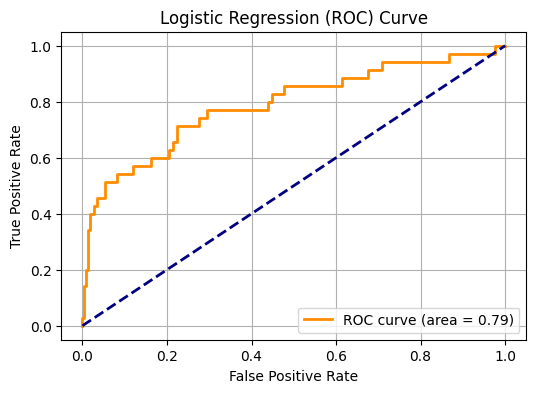

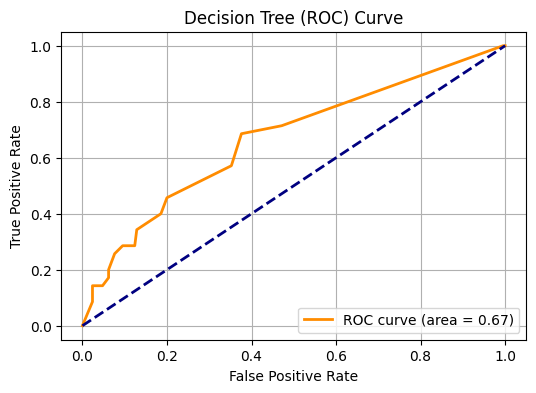

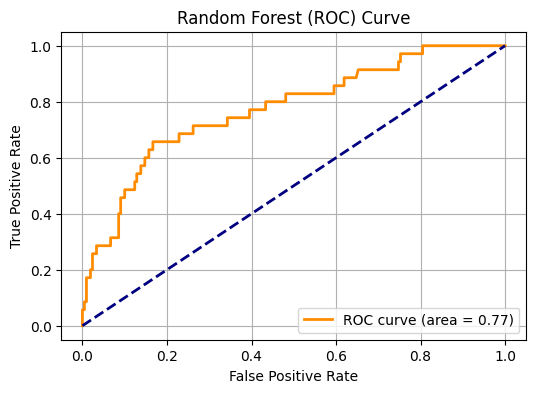

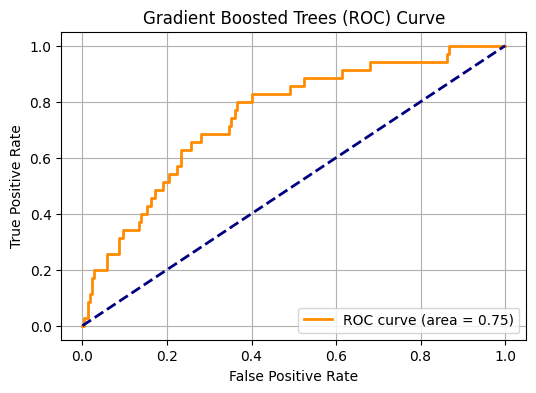

In [44]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np
from sklearn.metrics import roc_curve, auc


import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(predictions_df,model, label_col, prob_col="probability"):

    prob_col_values = predictions_df.select(prob_col).rdd.map(lambda x: x[0][1]).collect()
    labels = predictions_df.select(col(label_col)).rdd.map(lambda x: x[0]).collect()

    fpr, tpr, thresholds = roc_curve(labels, prob_col_values)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model} (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(lr_predictions, "Logistic Regression", label_col="Attrition_index", prob_col="probability")
plot_roc_curve(dt_predictions, "Decision Tree", label_col="Attrition_index", prob_col="probability")
plot_roc_curve(rf_predictions, "Random Forest", label_col="Attrition_index", prob_col="probability")
plot_roc_curve(gbt_predictions, "Gradient Boosted Trees", label_col="Attrition_index", prob_col="probability")


Visualizing the performance of each model

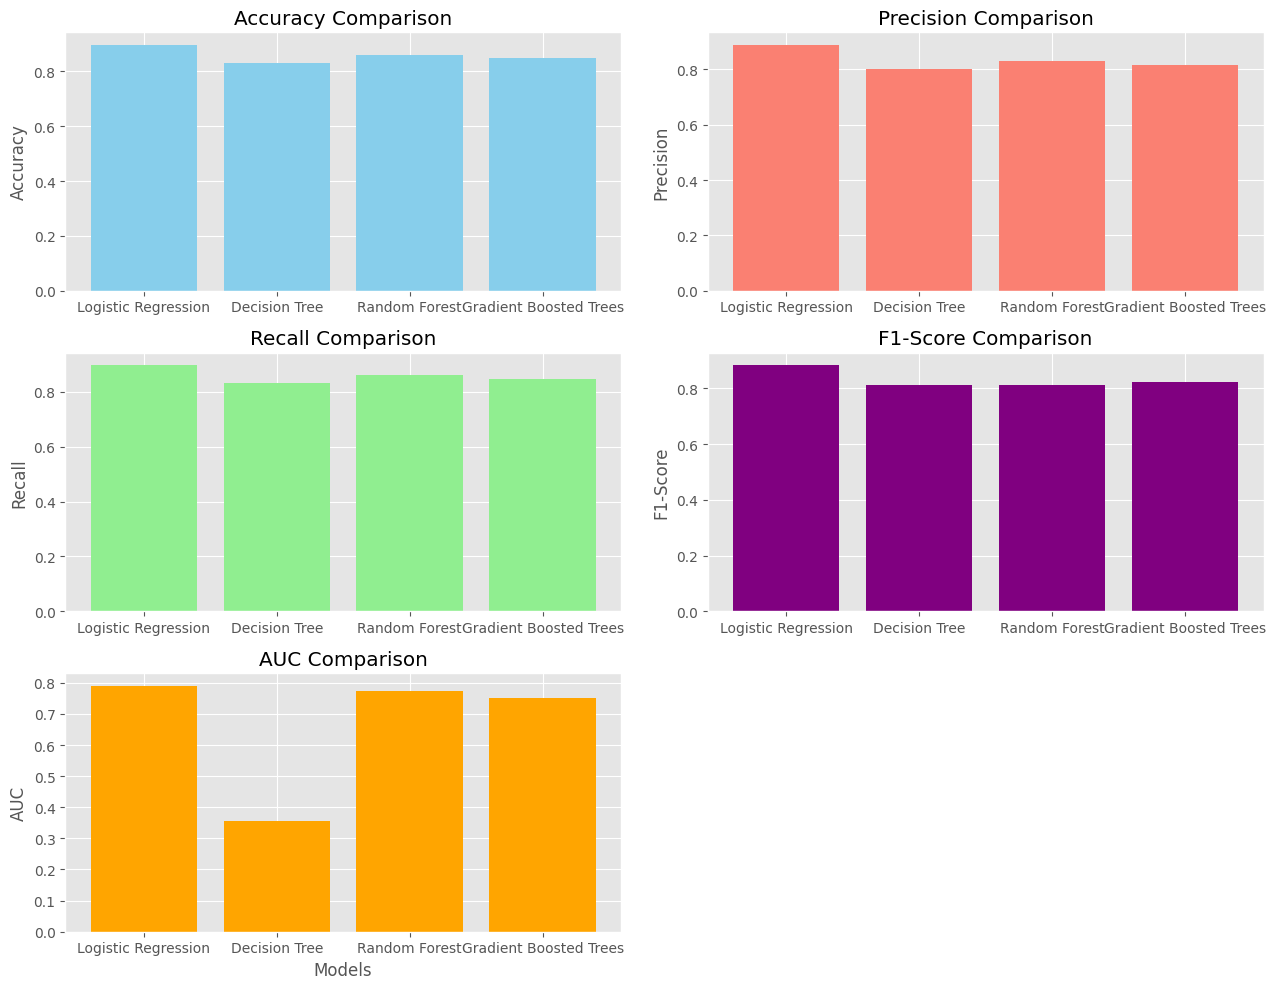

In [45]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig, axs = plt.subplots(3, 2, figsize=(13, 10))

# Plot Accuracy
axs[0, 0].bar(metrics_df_classification["Model"], metrics_df_classification["Accuracy"], color="skyblue")
axs[0, 0].set_title("Accuracy Comparison")
axs[0, 0].set_ylabel("Accuracy")

# Plot Precision
axs[0, 1].bar(metrics_df_classification["Model"], metrics_df_classification["Weightedprecision"], color="salmon")
axs[0, 1].set_title("Precision Comparison")
axs[0, 1].set_ylabel("Precision")

# Plot Recall
axs[1, 0].bar(metrics_df_classification["Model"], metrics_df_classification["Weightedrecall"], color="lightgreen")
axs[1, 0].set_title("Recall Comparison")
axs[1, 0].set_ylabel("Recall")

# Plot F1-Score
axs[1, 1].bar(metrics_df_classification["Model"], metrics_df_classification["F1"], color="purple")
axs[1, 1].set_title("F1-Score Comparison")
axs[1, 1].set_ylabel("F1-Score")

# Plot AUC
axs[2, 0].bar(metrics_df_classification["Model"], metrics_df_classification["AUC"], color="orange")
axs[2, 0].set_title("AUC Comparison")
axs[2, 0].set_ylabel("AUC")
axs[2, 0].set_xlabel("Models")

fig.delaxes(axs[2, 1])
plt.tight_layout()
plt.show()


Hypertuning

In [46]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_index", metricName="f1")

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 5.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100, 200]) \
    .addGrid(lr.tol, [1e-4, 1e-5]) \
    .build()

lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=f1_evaluator,
                       numFolds=5)

lr_cv_model = lr_cv.fit(train_data)

best_lr_model = lr_cv_model.bestModel
print("Best Logistic Regression Hyperparameters:", best_lr_model.extractParamMap())

lr_predictions_cv = best_lr_model.transform(test_data)

lr_f1_score = f1_evaluator.evaluate(lr_predictions_cv)
print(f"Logistic Regression F1 Score on Test Data: {lr_f1_score}")


Best Logistic Regression Hyperparameters: {Param(parent='LogisticRegression_ed197c574358', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_ed197c574358', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_ed197c574358', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_ed197c574358', name='featuresCol', doc='features column name.'): 'scaled_features', Param(parent='LogisticRegression_ed197c574358', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_ed197c574358', name='labelCol', doc='label column name.'): 'Attrition_index', Param(parent='LogisticRegression_ed197c574358', nam

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_index", metricName="f1")

dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15, 20]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10, 20]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_param_grid,
                       evaluator=f1_evaluator,
                       numFolds=5)

dt_cv_model = dt_cv.fit(train_data)

best_dt_model = dt_cv_model.bestModel
print("Best Decision Tree Hyperparameters:", best_dt_model.extractParamMap())

dt_predictions_cv = best_dt_model.transform(test_data)

dt_f1_score = f1_evaluator.evaluate(dt_predictions_cv)
print(f"Decision Tree F1 Score on Test Data: {dt_f1_score}")


Best Decision Tree Hyperparameters: {Param(parent='DecisionTreeClassifier_e415764a3f95', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeClassifier_e415764a3f95', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeClassifier_e415764a3f95', name='featuresCol', doc='features column name.'): 'scaled_features', Param(parent='DecisionTreeClassifier_e415764a3f95', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). 

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_index", metricName="f1")

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20, 30]) \
    .addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=f1_evaluator,
                       numFolds=5)

rf_cv_model = rf_cv.fit(train_data)

best_rf_model = rf_cv_model.bestModel
print("Best Random Forest Hyperparameters:", best_rf_model.extractParamMap())

rf_predictions_cv = best_rf_model.transform(test_data)

rf_f1_score = f1_evaluator.evaluate(rf_predictions_cv)
print(f"Random Forest F1 Score on Test Data: {rf_f1_score}")


Best Random Forest Hyperparameters: {Param(parent='RandomForestClassifier_8d85386ff15d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_8d85386ff15d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_8d85386ff15d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_8d85386ff15d', name='featureSubsetStrategy', doc="The number of features to consider f

--- Logistic Regression ---
Accuracy: 0.8816
Weightedprecision: 0.8686
Weightedrecall: 0.8816
F1: 0.8557
AUC: 0.7962




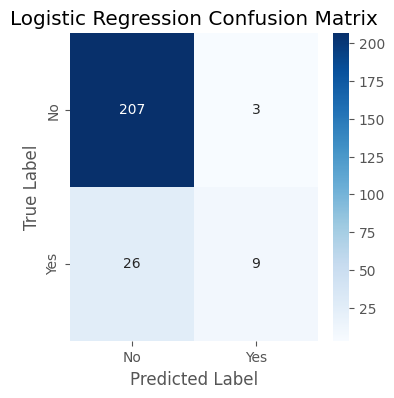

--- Decision Tree ---
Accuracy: 0.8367
Weightedprecision: 0.8169
Weightedrecall: 0.8367
F1: 0.8250
AUC: 0.3592




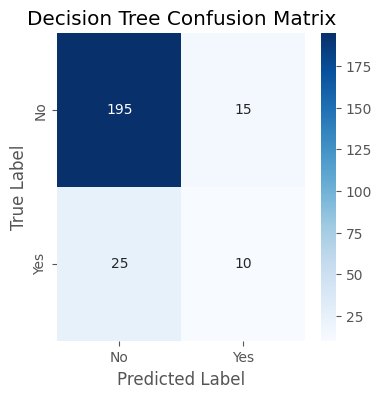

--- Random Forest ---
Accuracy: 0.8776
Weightedprecision: 0.8621
Weightedrecall: 0.8776
F1: 0.8489
AUC: 0.8048




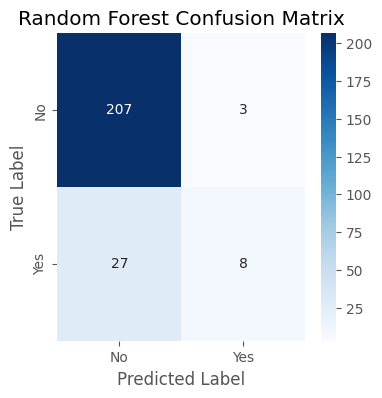

                 Model  Accuracy  Weightedprecision  Weightedrecall        F1  \
0  Logistic Regression  0.881633           0.868639        0.881633  0.855743   
1        Decision Tree  0.836735           0.816883        0.836735  0.825028   
2        Random Forest  0.877551           0.862138        0.877551  0.848917   

        AUC  
0  0.796190  
1  0.359184  
2  0.804762  


In [54]:
# Process predictions for each model
lr_metrics_cv = get_metrics_and_plot_confusion_matrix_with_auc(lr_predictions_cv, "Logistic Regression")
dt_metrics_cv = get_metrics_and_plot_confusion_matrix_with_auc(dt_predictions_cv, "Decision Tree")
rf_metrics_cv = get_metrics_and_plot_confusion_matrix_with_auc(rf_predictions_cv, "Random Forest")

# Combine metrics into a DataFrame
metrics_data_cv = [lr_metrics_cv, dt_metrics_cv, rf_metrics_cv]
metrics_df_classification_cv = pd.DataFrame(metrics_data_cv)

# Print the DataFrame
print(metrics_df_classification_cv)

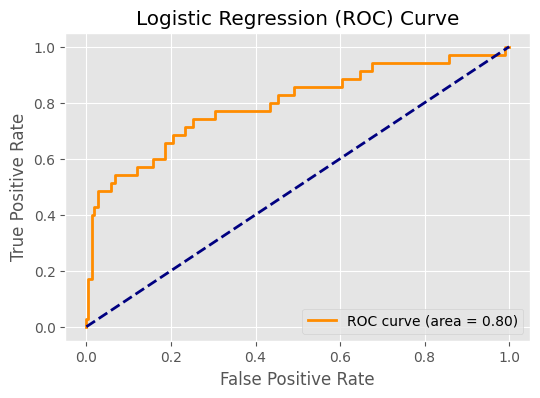

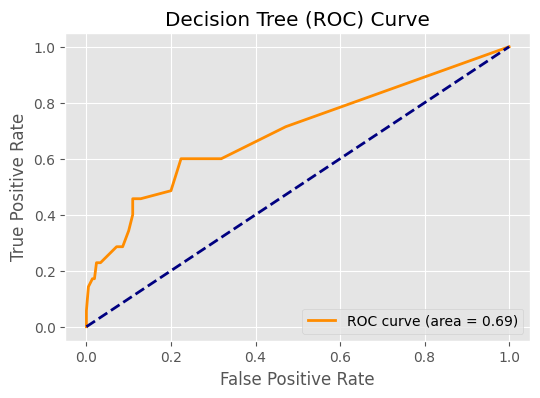

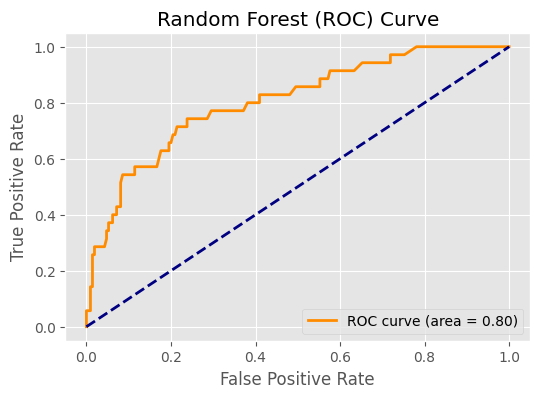

In [55]:
plot_roc_curve(lr_predictions_cv, "Logistic Regression", label_col="Attrition_index", prob_col="probability")
plot_roc_curve(dt_predictions_cv, "Decision Tree", label_col="Attrition_index", prob_col="probability")
plot_roc_curve(rf_predictions_cv, "Random Forest", label_col="Attrition_index", prob_col="probability")

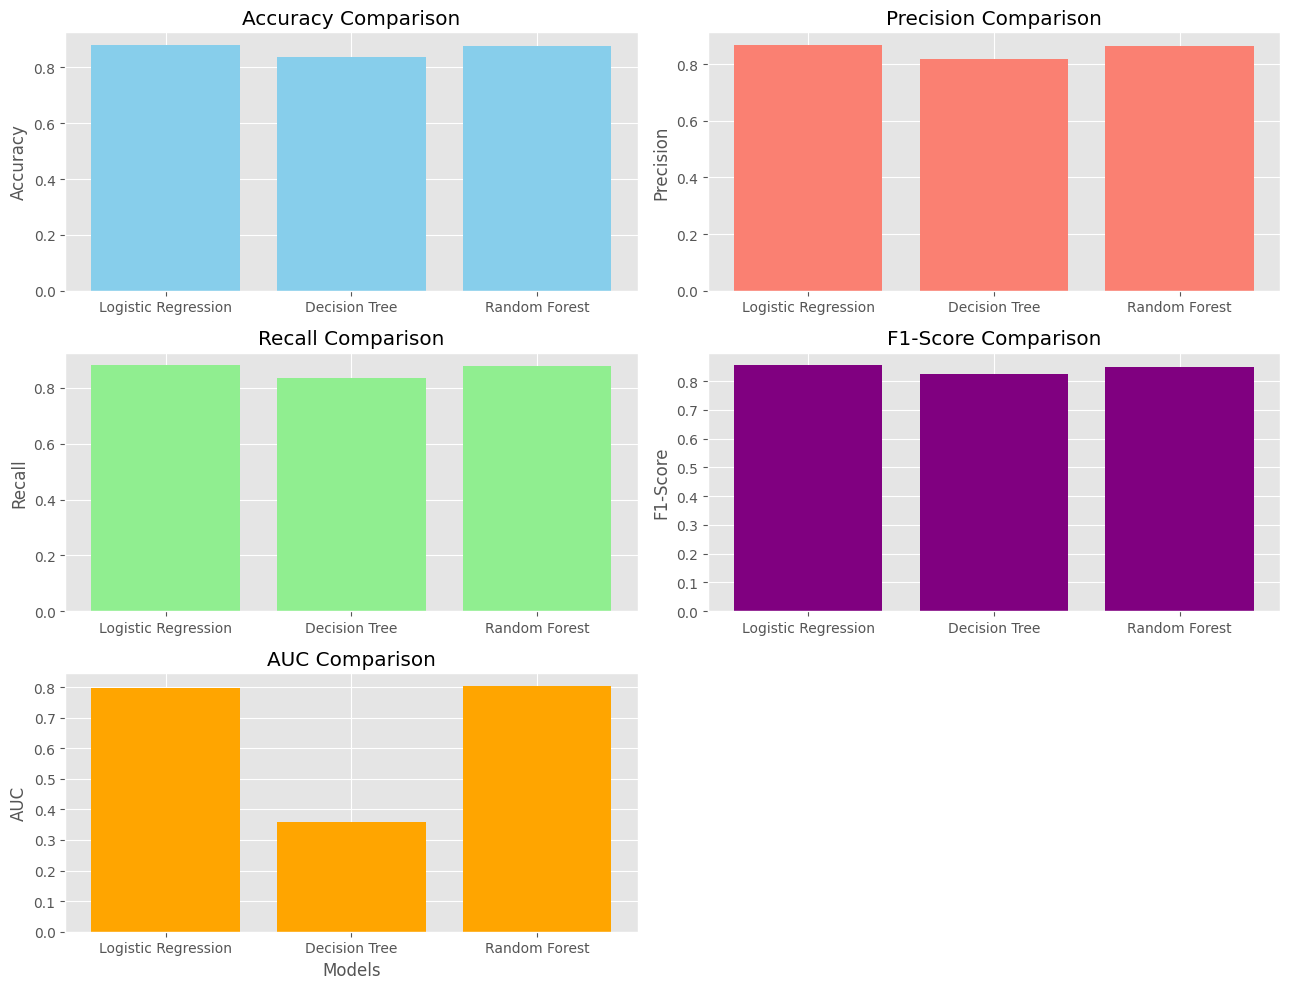

In [56]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig, axs = plt.subplots(3, 2, figsize=(13, 10))

# Plot Accuracy
axs[0, 0].bar(metrics_df_classification_cv["Model"], metrics_df_classification_cv["Accuracy"], color="skyblue")
axs[0, 0].set_title("Accuracy Comparison")
axs[0, 0].set_ylabel("Accuracy")

# Plot Precision
axs[0, 1].bar(metrics_df_classification_cv["Model"], metrics_df_classification_cv["Weightedprecision"], color="salmon")
axs[0, 1].set_title("Precision Comparison")
axs[0, 1].set_ylabel("Precision")

# Plot Recall
axs[1, 0].bar(metrics_df_classification_cv["Model"], metrics_df_classification_cv["Weightedrecall"], color="lightgreen")
axs[1, 0].set_title("Recall Comparison")
axs[1, 0].set_ylabel("Recall")

# Plot F1-Score
axs[1, 1].bar(metrics_df_classification_cv["Model"], metrics_df_classification_cv["F1"], color="purple")
axs[1, 1].set_title("F1-Score Comparison")
axs[1, 1].set_ylabel("F1-Score")

# Plot AUC
axs[2, 0].bar(metrics_df_classification_cv["Model"], metrics_df_classification_cv["AUC"], color="orange")
axs[2, 0].set_title("AUC Comparison")
axs[2, 0].set_ylabel("AUC")
axs[2, 0].set_xlabel("Models")

fig.delaxes(axs[2, 1])
plt.tight_layout()
plt.show()
